# Gaussian Naive Bayes Implementation

In [56]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

## Storing in an array all values and preprocessing

In [57]:
dataset_df1 = pd.read_csv(r"./premonsoon/ground_water_quality_2018_pre.csv")
dataset_df2 = pd.read_csv(r"./premonsoon/ground_water_quality_2019_pre.csv")
dataset_df3 = pd.read_csv(r"./premonsoon/ground_water_quality_2020_pre.csv")
dataset_df4 = pd.read_csv(r"./premonsoon/ground_water_quality_2021_pre.csv")
dataset_df5 = pd.read_csv(r"./premonsoon/ground_water_quality_2022_pre.csv")
dataset_df6 = pd.read_csv(r"./postmonsoon/ground_water_quality_2018_post.csv")
dataset_df7 = pd.read_csv(r"./postmonsoon/ground_water_quality_2019_post.csv")
dataset_df8 = pd.read_csv(r"./postmonsoon/ground_water_quality_2020_post.csv")
dataset_df9 = pd.read_csv(r"./postmonsoon/ground_water_quality_2021_post.csv")
dataset_df = pd.concat([dataset_df1,dataset_df2,dataset_df3,dataset_df4,dataset_df5,dataset_df6,dataset_df7,dataset_df8,dataset_df9],join='outer',ignore_index=True)
dataset_df.drop(columns=['RL_GIS','sno','village','mandal','district','gwl'],inplace=True)
dataset_df['season']=dataset_df['season'].astype(str).apply(lambda x: 0 if 'pre' in x.lower() else 1)

In [58]:
dataset_df['pH'] = pd.to_numeric(dataset_df['pH'], errors='coerce')

# Now convert to float
dataset_df['pH'] = dataset_df['pH'].astype(float)
dataset_df['RSC  meq  / L'] = pd.to_numeric(dataset_df['RSC  meq  / L'], errors='coerce')

# Now convert to float
dataset_df['RSC  meq  / L'] = dataset_df['RSC  meq  / L'].astype(float)

In [59]:
#To remove rows containing null values
for index, row in dataset_df.iterrows():
    if 'NA' in row.values:
        dataset_df.drop(index, inplace=True)
    elif(row['Classification']=='OG')or(row['Classification']=='O.G')or(row['Classification']=='BELOW THE GRAPH')or(row['Classification']=='OUT OF SAR GRAPH')or(row['Classification']=='BG'):
        dataset_df.drop(index, inplace=True)
dataset_df.reset_index(drop=True, inplace=True)

In [60]:
null_threshold = len(dataset_df) * 0.25
for column in dataset_df.columns:
    null_count = dataset_df[column].isnull().sum()
    if null_count > null_threshold:
        dataset_df.drop(column, axis=1, inplace=True)
    elif null_count > 0:
        dataset_df.dropna(subset=[column], inplace=True)
dataset_df.reset_index(drop=True, inplace=True)

In [61]:
dataset_df.columns

Index(['long_gis', 'lat_gis', 'season', 'pH', 'E.C', 'TDS', 'CO3', 'HCO3',
       'Cl', 'F', 'NO3 ', 'SO4', 'Na', 'K', 'Ca', 'Mg', 'T.H', 'SAR',
       'Classification', 'RSC  meq  / L', 'Classification.1'],
      dtype='object')

In [62]:
dataset_df.describe()

,long_gis,lat_gis,season,pH,E.C,TDS,CO3,HCO3,Cl,F,NO3,SO4,Na,K,Ca,Mg,T.H,SAR,RSC meq / L
count,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.00000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000
mean,66.772025,29.599037,0.387202,7.843799,1233.101610,789.881749,5.41146,268.275171,174.904218,1.037786,60.958889,49.644993,117.753836,8.560754,68.429224,47.475201,366.806037,2.790353,-1.865046
std,24.484076,24.306903,0.487160,0.458430,738.381329,473.032944,16.97257,128.542345,171.081966,0.812726,79.534434,63.171954,103.979699,21.907266,52.806161,34.073709,216.250298,2.589769,4.136058
min,0.000000,0.000000,0.000000,6.160000,102.000000,65.280000,0.00000,10.000000,10.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.100000,19.995888,0.140000,-59.584539
25%,77.770000,17.270000,0.000000,7.530000,750.000000,481.000000,0.00000,180.000000,60.000000,0.520000,13.488318,16.000000,53.000000,2.000000,32.000000,24.310000,220.000000,1.360000,-3.200000
50%,78.474600,17.970000,0.000000,7.880000,1047.000000,670.720000,0.00000,250.000000,120.000000,0.840000,36.000000,29.000000,88.000000,3.220000,56.000000,39.000000,320.000000,2.090000,-1.200000
75%,79.290000,19.024500,1.000000,8.180000,1520.000000,974.000000,0.00000,340.000000,220.000000,1.290000,74.559325,55.000000,145.450000,6.870000,88.000000,63.000000,459.893092,3.225302,0.001000
max,81.180000,81.180000,1.000000,10.590000,9499.000000,6079.360000,200.00000,1240.000000,2480.000000,13.700000,1028.000000,860.000000,1154.000000,356.000000,640.000000,457.028000,3479.226974,31.435063,18.200822


In [63]:
dataset_df.shape

(4907, 21)

In [64]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4907 entries, 0 to 4906
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   long_gis          4907 non-null   float64
 1   lat_gis           4907 non-null   float64
 2   season            4907 non-null   int64  
 3   pH                4907 non-null   float64
 4   E.C               4907 non-null   float64
 5   TDS               4907 non-null   float64
 6   CO3               4907 non-null   float64
 7   HCO3              4907 non-null   float64
 8   Cl                4907 non-null   float64
 9   F                 4907 non-null   float64
 10  NO3               4907 non-null   float64
 11  SO4               4907 non-null   float64
 12  Na                4907 non-null   float64
 13  K                 4907 non-null   float64
 14  Ca                4907 non-null   float64
 15  Mg                4907 non-null   float64
 16  T.H               4907 non-null   float64


In [65]:
all_labels=dataset_df['Classification'].unique()
for label in all_labels:
    print(label)

C3S1
C2S1
C3S2
C4S1
C4S2
C1S1
C4S3
C4S4
C3S3
C3S4
C2S2


In [66]:
print(len(dataset_df[dataset_df['Classification']=='OG']),len(dataset_df[dataset_df['Classification']=='O.G']),len(dataset_df[dataset_df['Classification']=='BELOW THE GRAPH']),len(dataset_df[dataset_df['Classification']=='OUT OF SAR GRAPH']),len(dataset_df[dataset_df['Classification']=='BG']))

0 0 0 0 0


In [67]:
#encoding/labelling the target column
label_mapping = {
    label: index for index, label in enumerate(dataset_df['Classification'].unique())
}
# Map labels to numerical values
dataset_df['Classification'] = dataset_df['Classification'].map(label_mapping)
dataset_df['Classification'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [68]:
label_mapping

{'C3S1': 0,
 'C2S1': 1,
 'C3S2': 2,
 'C4S1': 3,
 'C4S2': 4,
 'C1S1': 5,
 'C4S3': 6,
 'C4S4': 7,
 'C3S3': 8,
 'C3S4': 9,
 'C2S2': 10}

In [69]:
#standardisation of the data
means = dataset_df.drop(columns=['Classification','Classification.1']).mean()
stds = dataset_df.drop(columns=['Classification','Classification.1']).std()
for col in dataset_df.columns:
    if col != 'Classification' and col != 'Classification.1':  # Exclude target column from standardization
        dataset_df[col] = (dataset_df[col] - means[col]) / stds[col]
#min max scaling
#for col in dataset_df.columns:
#    if col != 'Classification' and col!='Classification.1':  # Exclude the target column
#        min_val = dataset_df[col].min()
#        max_val = dataset_df[col].max()
#        dataset_df[col] = (dataset_df[col] - min_val) / (max_val - min_val)

In [70]:
# randomising the dataframe and splitting to get train and test dataframes
dataset_df = dataset_df.sample(frac=1, random_state=42)
num_rows = len(dataset_df)
train_size = int(0.8 * num_rows)
test_size = num_rows - train_size
# Split the DataFrame into training and testing sets
train_dataset_df = dataset_df.head(train_size)
test_dataset_df = dataset_df.tail(test_size)

## Gaussian Naive Bayes algorithm

In [71]:
X_train = train_dataset_df.drop(columns=['Classification','Classification.1'], axis=1).values
y_train = train_dataset_df['Classification'].values
X_test = test_dataset_df.drop(columns=['Classification','Classification.1'], axis=1).values
y_test = test_dataset_df['Classification'].values
print("The shape of training data is (it is a dataframe):",X_train.shape)
num_of_features=X_train.shape[1]
num_of_classes=len(label_mapping)

The shape of training data is (it is a dataframe): (3925, 19)


In [72]:
class GaussianNaiveBayes:
    def __init__(self):
        self.class_prior = None
        self.class_mean = None
        self.class_variance = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        # Initialize arrays to store class prior, mean, and variance
        self.class_prior = np.zeros(n_classes)
        self.class_mean = np.zeros((n_classes, n_features))
        self.class_variance = np.zeros((n_classes, n_features))
        # Compute class prior, mean, and variance for each class
        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            print(X_c.shape)
            self.class_prior[i] = len(X_c) / n_samples
            self.class_mean[i, :] = X_c.mean(axis=0)
            self.class_variance[i, :] = X_c.var(axis=0)

    def predict(self, X):
        y_pred = [self._predict_sample(x) for x in X]
        return np.array(y_pred)
    def predict_probabilities(self,x):
        posteriors = []
        # Compute posterior probability for each class
        for i, c in enumerate(self.classes):
            prior = self.class_prior[i]
            class_conditional = np.prod(self._pdf(i, x)) # Changed to product instead of sum
            posterior = prior * class_conditional
            posteriors.append(posterior)
        return posteriors
    def _predict_sample(self, x):
        posteriors = self.predict_probabilities(x)
        # Predict class label with maximum posterior probability
        return self.classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean = self.class_mean[class_idx]
        variance = self.class_variance[class_idx]
        numerator = np.exp(-(x - mean) ** 2 / ((2 * variance)+1e-10))
        denominator = np.sqrt(2 * np.pi * variance)

        # Handle potential division by zero errors
        denominator[denominator == 0] = 1e-10
        return numerator / denominator
    
    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    def precision(self, y_true, y_pred):
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        # Handle potential division by zero errors
        if tp + fp == 0:
            return 0
        return tp / (tp + fp)

    def recall(self, y_true, y_pred):
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        # Handle potential division by zero errors
        if tp + fn == 0:
            return 0
        return tp / (tp + fn)

    def f1_score(self, y_true, y_pred):
        precision_val = self.precision(y_true, y_pred)
        recall_val = self.recall(y_true, y_pred)
        # Handle potential division by zero errors
        if precision_val + recall_val == 0:
            return 0
        return 2 * (precision_val * recall_val) / (precision_val + recall_val)
        
    def plot_confusion_matrix(self, confusion_matrix):
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xticks(ticks=range(len(label_mapping)), labels=label_mapping.keys())
        plt.yticks(ticks=range(len(label_mapping)), labels=label_mapping.keys())
        plt.title("Confusion Matrix")
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()


In [73]:
nb_classifier = GaussianNaiveBayes()
nb_classifier.fit(X_train, y_train)

(2477, 19)
(943, 19)
(92, 19)
(184, 19)
(119, 19)
(44, 19)
(20, 19)
(24, 19)
(18, 19)
(4, 19)


In [74]:
y_pred = nb_classifier.predict(X_test)

In [75]:
print("Precision is :",nb_classifier.precision(y_test,y_pred))
print("Accuracy is :",nb_classifier.accuracy(y_test,y_pred))
print("Recall is :",nb_classifier.recall(y_test,y_pred))
print("F1-Score is :",nb_classifier.f1_score(y_test,y_pred))

Precision is : 0.7896678966789668
Accuracy is : 0.8329938900203666
Recall is : 0.9683257918552036
F1-Score is : 0.8699186991869918


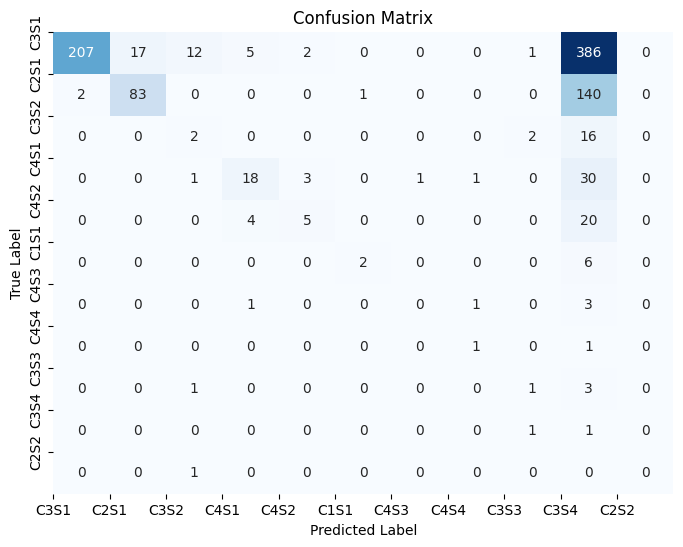

In [21]:
confusion = confusion_matrix(y_test, y_pred)
nb_classifier.plot_confusion_matrix(confusion)

## sklearns implementation and results

Accuracy: 0.8329938900203666
Precision: 0.41505683733787946
Recall: 0.5671828871859388
F1 Score: 0.4511183678027312


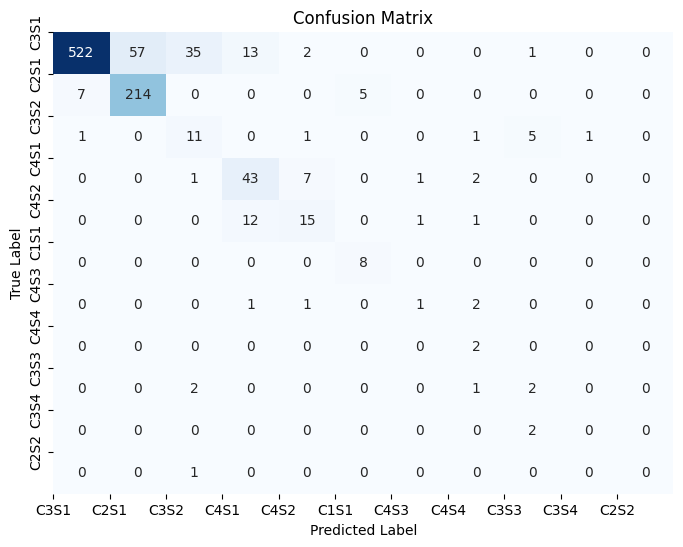

In [76]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Create and fit Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Make predictions
y_pred = gnb.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Print confusion matrix
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xticks(ticks=range(len(label_mapping)), labels=label_mapping.keys())
plt.yticks(ticks=range(len(label_mapping)), labels=label_mapping.keys())
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## On reduced dataset

In [54]:
dataset_df_1 = pd.read_csv(r"C:\Users\koush\Desktop\GroundWater_analyzer\Reduced_features_dataset.csv")
#To remove rows containing null values
for index, row in dataset_df_1.iterrows():
    if 'NA' in row.values:
        dataset_df_1.drop(index, inplace=True)
    elif(row['Classification']=='OG')or(row['Classification']=='O.G')or(row['Classification']=='BELOW THE GRAPH')or(row['Classification']=='OUT OF SAR GRAPH')or(row['Classification']=='BG'):
        dataset_df_1.drop(index, inplace=True)
dataset_df_1.reset_index(drop=True, inplace=True)
null_threshold = len(dataset_df_1) * 0.25
for column in dataset_df_1.columns:
    null_count = dataset_df_1[column].isnull().sum()
    if null_count > null_threshold:
        dataset_df_1.drop(column, axis=1, inplace=True)
    elif null_count > 0:
        dataset_df_1.dropna(subset=[column], inplace=True)
dataset_df_1.reset_index(drop=True, inplace=True)
print(dataset_df_1.shape)
#encoding/labelling the target column
label_mapping = {
    label: index for index, label in enumerate(dataset_df_1['Classification'].unique())
}
# Map labels to numerical values
dataset_df_1['Classification'] = dataset_df_1['Classification'].map(label_mapping)
dataset_df_1['Classification'].unique()
# randomising the dataframe and splitting to get train and test dataframes
dataset_df_1 = dataset_df_1.sample(frac=1, random_state=42)
print(dataset_df_1.shape)
num_rows = len(dataset_df_1)
train_size = int(0.8 * num_rows)
test_size = num_rows - train_size
# Split the DataFrame into training and testing sets
train_dataset_df_1 = dataset_df_1.head(train_size)
test_dataset_df_1 = dataset_df_1.tail(test_size)
print(train_dataset_df_1.shape)
X_train_2 = train_dataset_df_1.drop(columns=['Classification'], axis=1).values
y_train_2 = train_dataset_df_1['Classification'].values
X_test_2 = test_dataset_df_1.drop(columns=['Classification'], axis=1).values
y_test_2 = test_dataset_df_1['Classification'].values
print("The shape of training data is (it is a dataframe):",X_train_2.shape)
num_of_features=X_train_2.shape[1]
num_of_classes=len(label_mapping)

(4907, 9)
(4907, 9)
(3925, 9)
The shape of training data is (it is a dataframe): (3925, 8)


(2477, 8)
(943, 8)
(92, 8)
(184, 8)
(119, 8)
(44, 8)
(20, 8)
(24, 8)
(18, 8)
(4, 8)
Precision is : 0.7896678966789668
Accuracy is : 0.8329938900203666
Recall is : 0.9683257918552036
F1-Score is : 0.8699186991869918


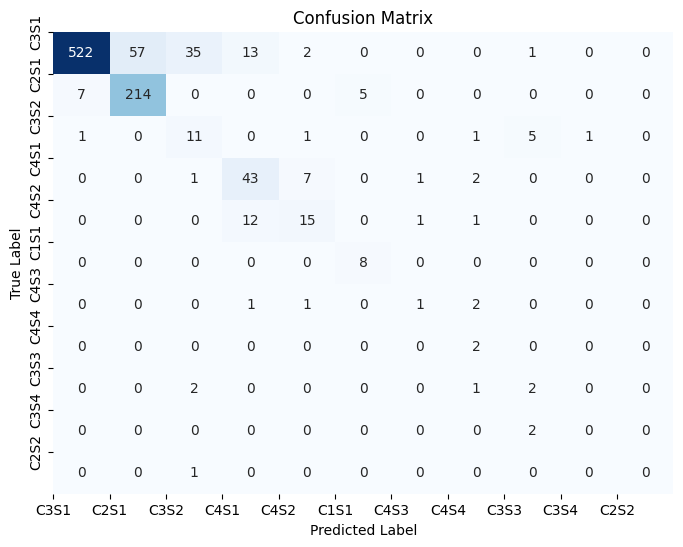

In [55]:
nb_classifier_1 = GaussianNaiveBayes()
nb_classifier_1.fit(X_train_2, y_train_2)
y_pred = nb_classifier.predict(X_test)
print("Precision is :",nb_classifier.precision(y_test,y_pred))
print("Accuracy is :",nb_classifier.accuracy(y_test,y_pred))
print("Recall is :",nb_classifier.recall(y_test,y_pred))
print("F1-Score is :",nb_classifier.f1_score(y_test,y_pred))
confusion = confusion_matrix(y_test, y_pred)
nb_classifier.plot_confusion_matrix(confusion)

Accuracy: 0.8421588594704684
Precision: 0.3926339130544257
Recall: 0.504567757878713
F1 Score: 0.4220245797975954


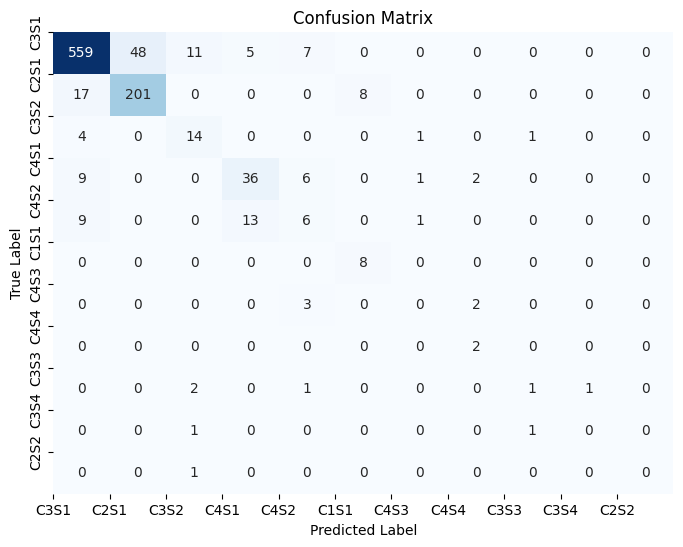

In [77]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Create and fit Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_train_2, y_train_2)

# Make predictions
y_pred = gnb.predict(X_test_2)

# Calculate metrics
accuracy = accuracy_score(y_test_2, y_pred)
precision = precision_score(y_test_2, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test_2, y_pred, average='macro')
f1 = f1_score(y_test_2, y_pred, average='macro')

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Print confusion matrix
confusion = confusion_matrix(y_test_2, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xticks(ticks=range(len(label_mapping)), labels=label_mapping.keys())
plt.yticks(ticks=range(len(label_mapping)), labels=label_mapping.keys())
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()